## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ARIMA,auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from matplotlib.pyplot import vlines


import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings('ignore')


## Loading the data

In [2]:
data = pd.read_csv('Final_Data.csv')

In [3]:
data

,Date,Customer_Name,Item_Name,Vrh_No,Quantity,Price_per_unit,Amount
0,2019-01-04,customer1,Item_1,1,200.0,20.0,4000.0
1,2019-01-04,customer1,Item_2,1,160.0,28.0,4480.0
2,2019-01-04,customer1,Item_3,1,12.0,60.0,720.0
3,2019-01-04,customer1,Item_3,1,15.0,35.0,525.0
4,2019-01-04,customer1,Item_3,1,25.0,25.0,625.0
...,...,...,...,...,...,...,...
1952,2021-04-02,customer17,Item_34,331,500.0,70.0,35000.0
1953,2021-04-02,customer5,Item_1,332,2400.0,20.0,48000.0
1954,2021-05-02,customer129,Item_2,333,340.0,25.5,8670.0
1955,2021-05-02,customer16,Item_33,334,123.4,30.0,3702.0


In [4]:
# Grouping the 'Quantity' column by 'Date' in the 'data' DataFrame and aggregating the sum of the grouped values
df = data.groupby('Date')['Quantity'].sum().reset_index()

In [5]:
# Renaming the "Quantity" column to "Demand"
df.rename(columns = {'Quantity':'Demand'}, inplace = True)

In [6]:
# Extracting the year from the "Date" column
df['year'] = pd.DatetimeIndex(df['Date']).year
df

,Date,Demand,year
0,2019-01-04,5792.00,2019
1,2019-01-05,785.20,2019
2,2019-01-06,3367.50,2019
3,2019-01-10,1144.00,2019
4,2019-01-11,2294.75,2019
...,...,...,...
277,2021-07-01,3828.00,2021
278,2021-08-01,2855.50,2021
279,2021-09-01,1258.45,2021
280,2021-11-01,1197.00,2021


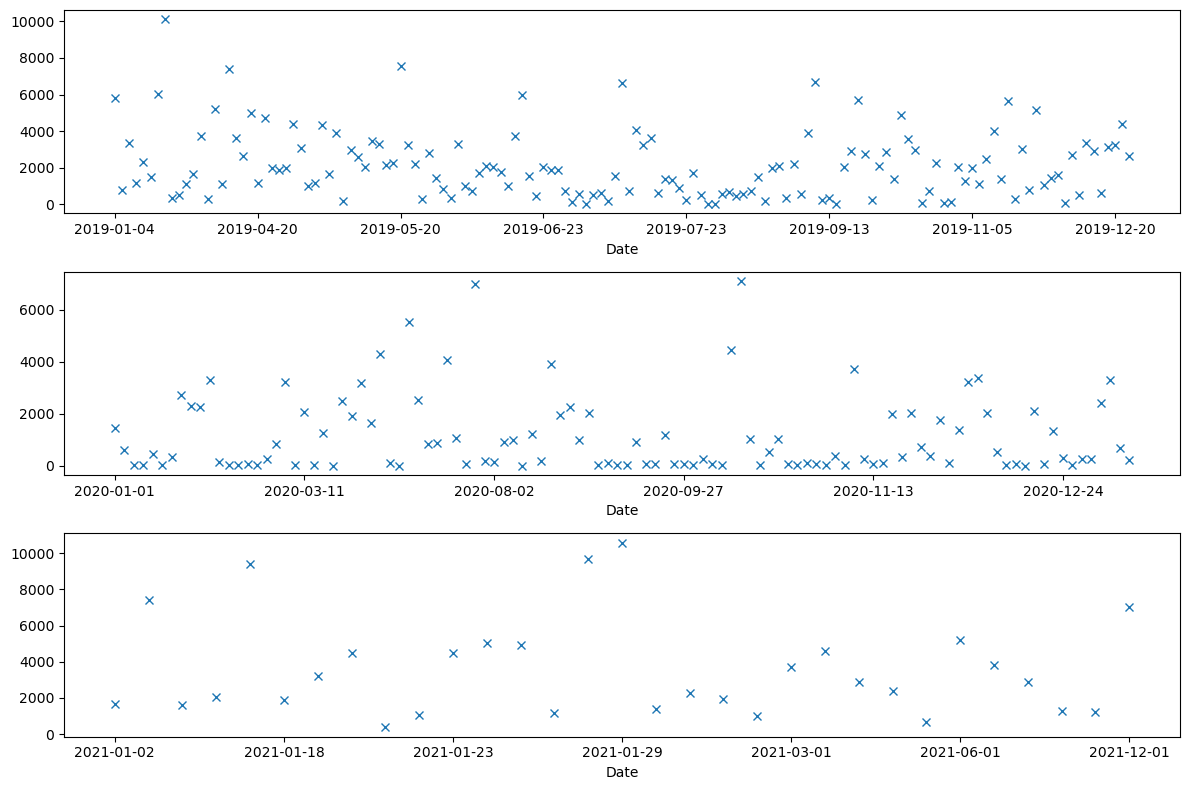

In [7]:
# Ploting time series data grouped by year
years= df.year.unique()
number_years= len(years)
fig, axes = plt.subplots(number_years, 1, figsize=(12, 8))
for i, year in enumerate(years):
    (df.set_index('Date')
       .loc[lambda df: df.year == year]
       .plot(y='Demand', ax=axes[i],marker='x',linestyle=""))    
    axes[i].legend_.remove()
fig.set_tight_layout("tight")

In [8]:
# Dropping the column beacuse it will not be required further
df.drop(['year'], axis=1,inplace=True)

In [9]:
df.dtypes

Date       object
Demand    float64
dtype: object

In [10]:
# Converting the datatype of "Date" column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.dtypes

Date      datetime64[ns]
Demand           float64
dtype: object

In [12]:
df['Date'].min()

Timestamp('2019-01-04 00:00:00')

In [13]:
df['Date'].max()

Timestamp('2021-12-01 00:00:00')

**Data is from 4th January 2019 to 1st December 2021**

In [14]:
# Sorting the values of the df dataframe by date in ascending order
df.sort_values("Date", inplace = True)

In [15]:
# Setting the "Date" column as the index of the "df" DataFrame
df.set_index('Date', inplace=True) 

In [16]:
# Creating a new time series dataframe that has monthly aggregated mean of demand
df1 = df['Demand'].resample('M').mean()

In [17]:
# Interpolation is a technique used to estimate unknown data points between two known data points.
df1=df1.interpolate(limit_direction="both")
df1

Date
2019-01-31    2481.075000
2019-02-28    3292.958333
2019-03-31    2018.925000
2019-04-30    3169.865625
2019-05-31    2514.200000
2019-06-30    1646.505000
2019-07-31    1498.557895
2019-08-31    1026.209091
2019-09-30    2311.128571
2019-10-31    2115.103333
2019-11-30    2089.470000
2019-12-31    2601.283333
2020-01-31    1143.458333
2020-02-29      83.000000
2020-03-31    1244.125000
2020-04-30    1259.275000
2020-05-31    2249.266667
2020-06-30    2213.496667
2020-07-31    2204.038333
2020-08-31    1168.340000
2020-09-30     565.850000
2020-10-31     956.749375
2020-11-30    1048.695455
2020-12-31    1141.655263
2021-01-31    4038.118889
2021-02-28    1481.000000
2021-03-31    3711.600000
2021-04-30    3735.520000
2021-05-31    1538.275000
2021-06-30    5207.550000
2021-07-31    3828.000000
2021-08-31    2855.500000
2021-09-30    1258.450000
2021-10-31    1227.725000
2021-11-30    1197.000000
2021-12-31    7029.000000
Freq: M, Name: Demand, dtype: float64

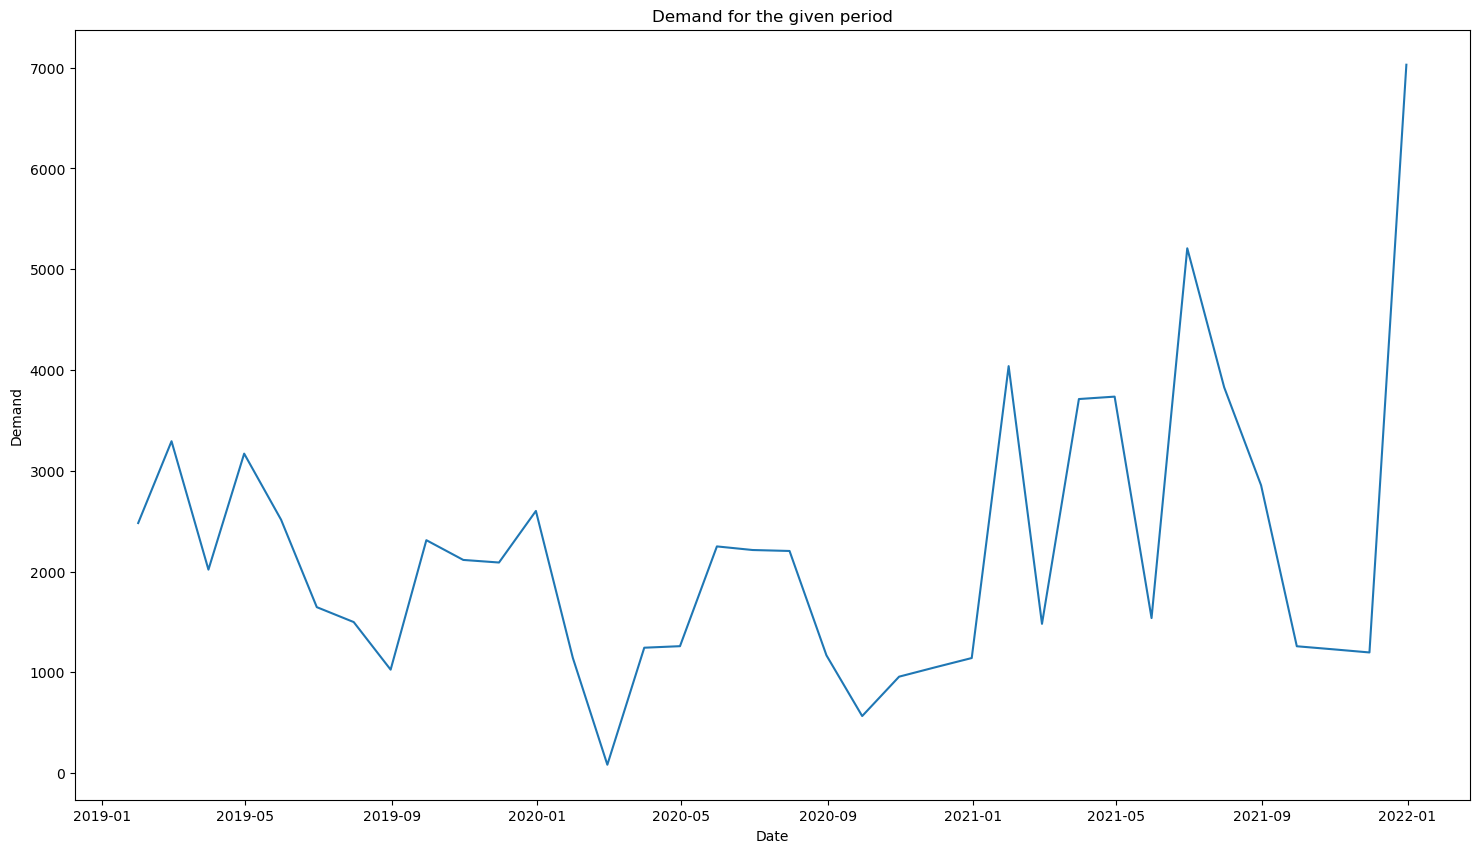

In [18]:
# Creating a line plot of the "Demand" data for the given period
plt.figure(figsize=(18,10))
plt.title('Demand for the given period')
sns.lineplot(data = df1)
plt.show()

**Demand is very low for starting of year 2020 and highest for ending of year 2021**

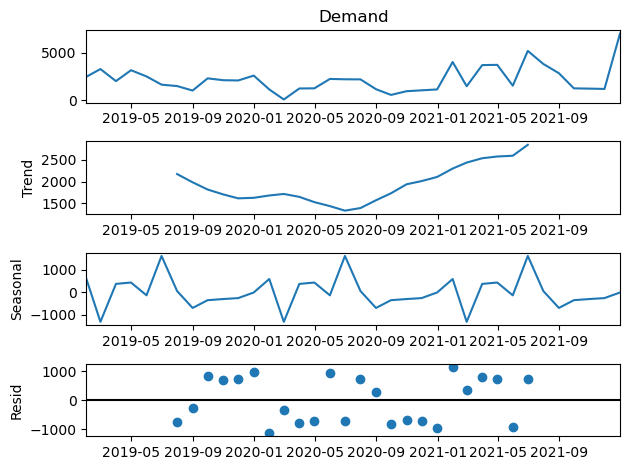

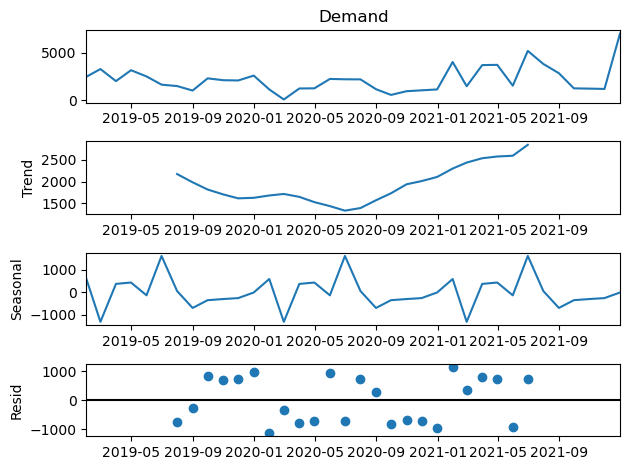

In [19]:
# Performing a time series decomposition
Decomposed_Series = seasonal_decompose(df1,model='additive')
Decomposed_Series.plot()

### Split in test and train in exactly 70 and 30% 

In [20]:
def split(df):
    size=int(len(df)*0.7)
    Train = df.iloc[:size]  # 70 %
    Test = df.iloc[size:] # 30 %
    return Train,Test

In [21]:
Train,Test = split(df1)

In [22]:
Train.shape

(25,)

In [23]:
Test.shape

(11,)

### Function for plotting and validating

In [24]:
def PlotValidation(model,df):
    Forecast = model.forecast(11).rename('Forecast') # Model Forecasting
    # Act, Forecast combining
    Actual_Forecast_Df = pd.concat([df, Forecast], axis = 1) 
    # Plot
    plt.figure(figsize=(18,10))
    sns.lineplot(data = Actual_Forecast_Df)
    plt.show()
    ## Validation
    Validation_Df = Actual_Forecast_Df[-11:].copy()
    print("MAPE",np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100) # MAPE
    print("RMSE",np.sqrt(np.mean((Validation_Df['Demand'] - Validation_Df['Forecast'])**2))) #RMSE

### Simple Exponential Smoothing (SES)

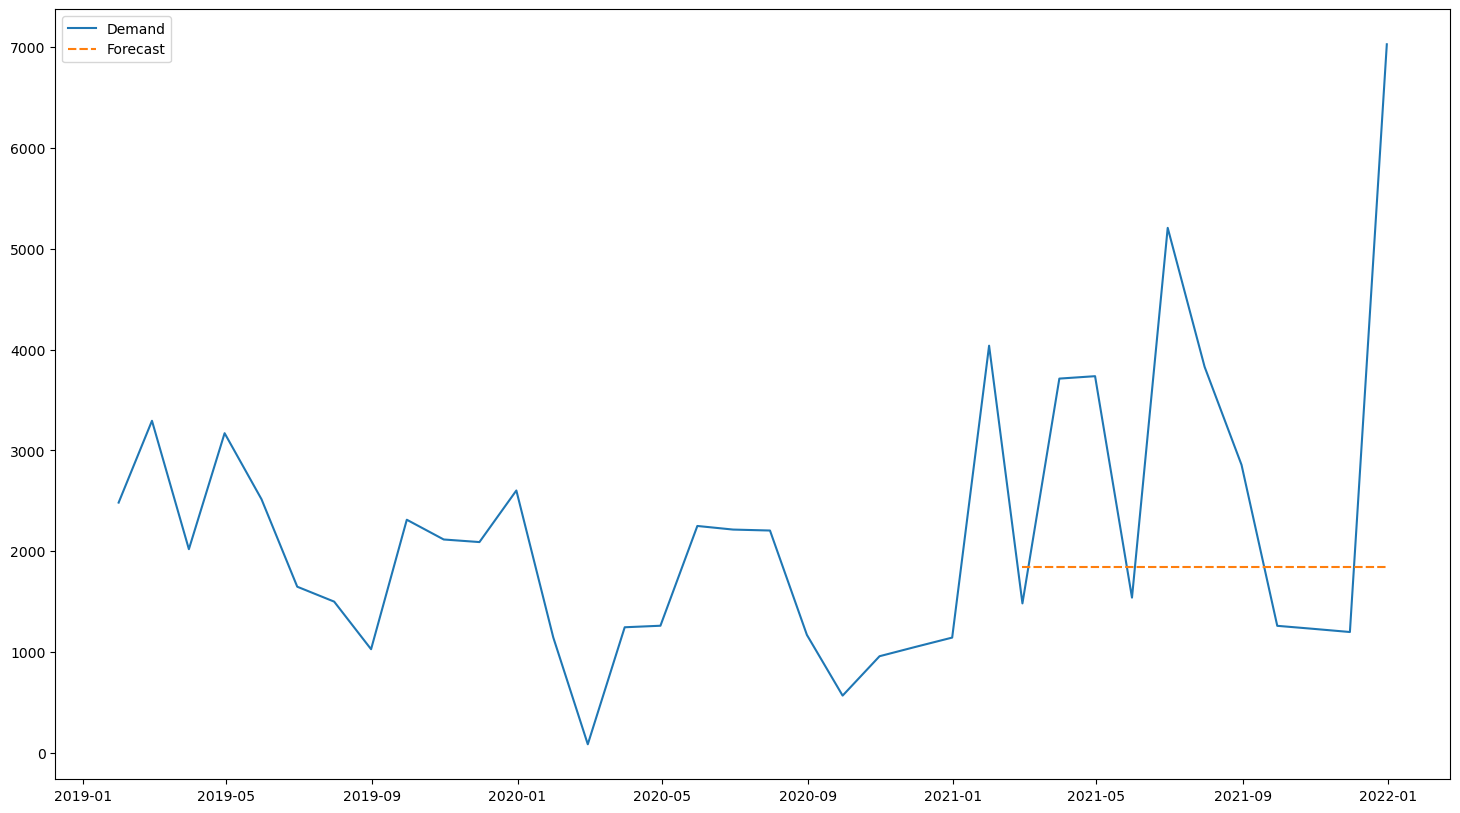

MAPE 47.41663379999169
RMSE 2165.9584226630213


In [25]:
SES = SimpleExpSmoothing(Train).fit()
PlotValidation(SES,df1)

### Double Exponential Smoothing (DES)

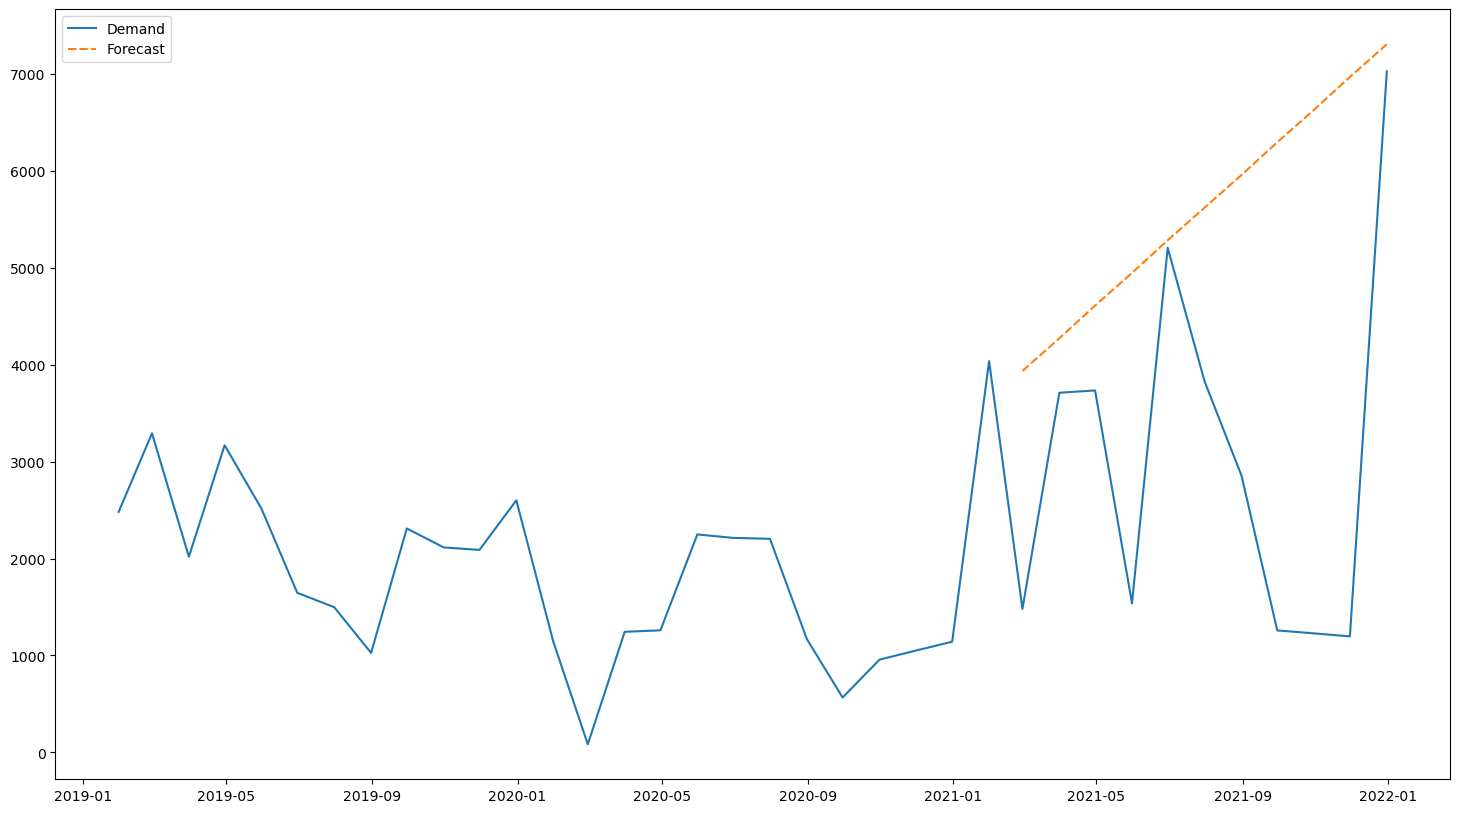

MAPE 173.68287692604721
RMSE 3298.3178547733096


In [26]:
DES = Holt(Train).fit()
PlotValidation(DES,df1)

In [27]:
# Finding best parameters for DES

myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        print(alpha, beta)
        DES = Holt(Train).fit(smoothing_level = alpha,smoothing_slope = beta)
        Forecast = DES.forecast(11).rename('Forecast')
        Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-11:].copy()
        tempMAPE = np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100 # MAPE
            
            
        alphaList.append(alpha)
        betaList.append(beta)
        mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("DES.csv")

0.0 0.0
0.0 0.1
0.0 0.2
0.0 0.3
0.0 0.4
0.0 0.5
0.0 0.6
0.0 0.7
0.0 0.8
0.0 0.9
0.0 1.0
0.1 0.0
0.1 0.1
0.1 0.2
0.1 0.3
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7
0.1 0.8
0.1 0.9
0.1 1.0
0.2 0.0
0.2 0.1
0.2 0.2
0.2 0.3
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7
0.2 0.8
0.2 0.9
0.2 1.0
0.3 0.0
0.3 0.1
0.3 0.2
0.3 0.3
0.3 0.4
0.3 0.5
0.3 0.6
0.3 0.7
0.3 0.8
0.3 0.9
0.3 1.0
0.4 0.0
0.4 0.1
0.4 0.2
0.4 0.3
0.4 0.4
0.4 0.5
0.4 0.6
0.4 0.7
0.4 0.8
0.4 0.9
0.4 1.0
0.5 0.0
0.5 0.1
0.5 0.2
0.5 0.3
0.5 0.4
0.5 0.5
0.5 0.6
0.5 0.7
0.5 0.8
0.5 0.9
0.5 1.0
0.6 0.0
0.6 0.1
0.6 0.2
0.6 0.3
0.6 0.4
0.6 0.5
0.6 0.6
0.6 0.7
0.6 0.8
0.6 0.9
0.6 1.0
0.7 0.0
0.7 0.1
0.7 0.2
0.7 0.3
0.7 0.4
0.7 0.5
0.7 0.6
0.7 0.7
0.7 0.8
0.7 0.9
0.7 1.0
0.8 0.0
0.8 0.1
0.8 0.2
0.8 0.3
0.8 0.4
0.8 0.5
0.8 0.6
0.8 0.7
0.8 0.8
0.8 0.9
0.8 1.0
0.9 0.0
0.9 0.1
0.9 0.2
0.9 0.3
0.9 0.4
0.9 0.5
0.9 0.6
0.9 0.7
0.9 0.8
0.9 0.9
0.9 1.0
1.0 0.0
1.0 0.1
1.0 0.2
1.0 0.3
1.0 0.4
1.0 0.5
1.0 0.6
1.0 0.7
1.0 0.8
1.0 0.9
1.0 1.0


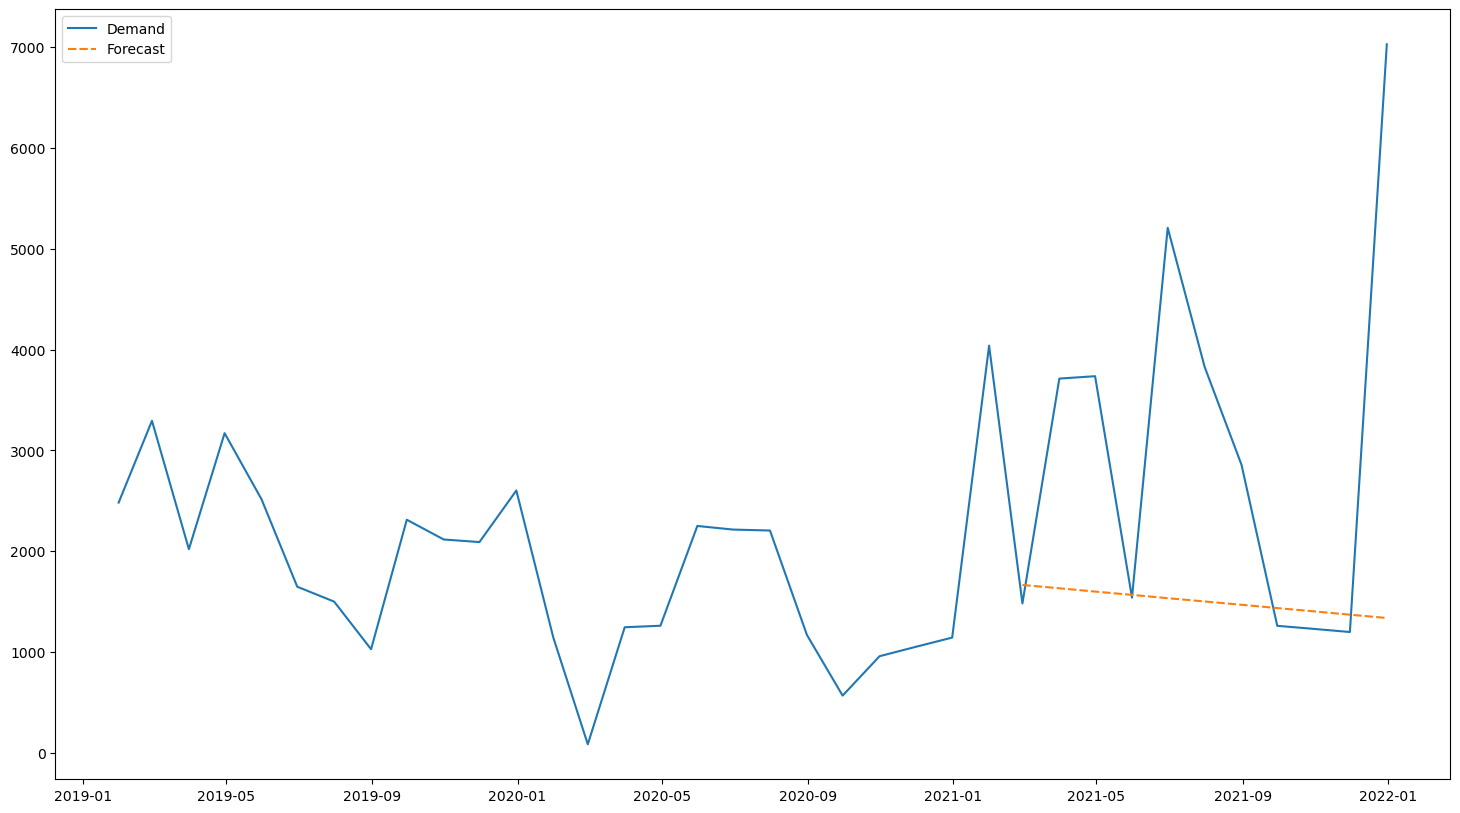

MAPE 39.17303837896338
RMSE 2379.461525150599


In [28]:
DES = Holt(Train).fit(smoothing_level = 0.2,smoothing_slope = 0)
PlotValidation(DES,df1)

### Triple Exponential Smoothing (TES)

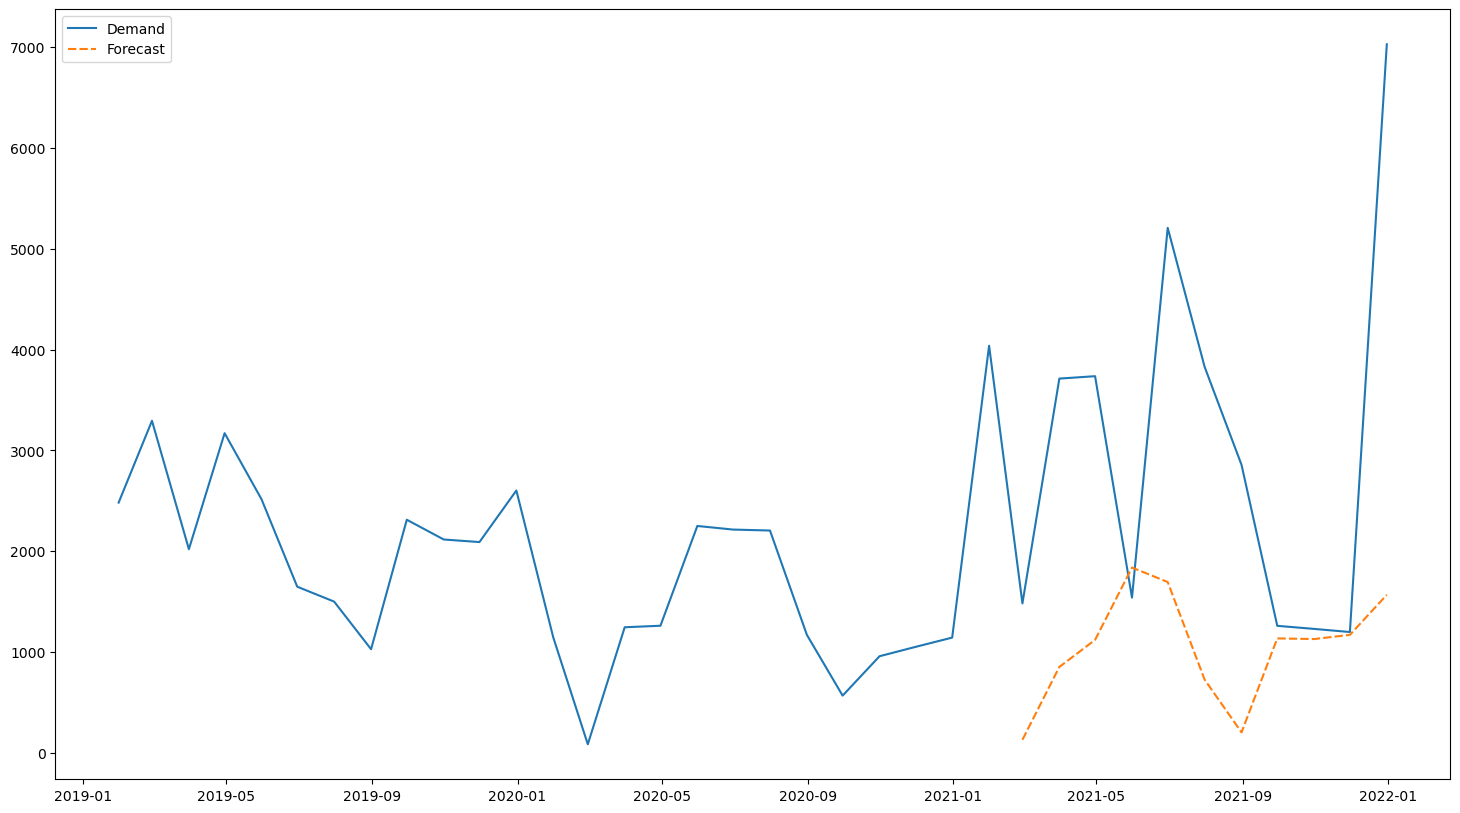

MAPE 54.3286121968984
RMSE 2625.940041845812


In [29]:
TES = ExponentialSmoothing(Train,seasonal='add',trend = 'add').fit()
PlotValidation(TES,df1)

In [30]:
# # Finding best parameters for TES 

myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)
myGamma = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
gammaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        for gamma in myGamma:
            
            print(alpha, beta, gamma)
                                              
            TES = ExponentialSmoothing(Train, 
                           seasonal='add', # seasonal='add'
                           trend = 'add').fit(smoothing_level = alpha, 
                                      smoothing_slope = beta, 
                                      smoothing_seasonal = gamma)
            
            Forecast = TES.forecast(11).rename('Forecast')
            Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)
            Validation_Df = Actual_Forecast_Df[-11:].copy()
            tempMAPE = np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100 # MAPE
            
            
            alphaList.append(alpha)
            betaList.append(beta)
            gammaList.append(gamma)
            mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "gamma": gammaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("dTES.csv")

0.0 0.0 0.0
0.0 0.0 0.1
0.0 0.0 0.2
0.0 0.0 0.3
0.0 0.0 0.4
0.0 0.0 0.5
0.0 0.0 0.6
0.0 0.0 0.7
0.0 0.0 0.8
0.0 0.0 0.9
0.0 0.0 1.0
0.0 0.1 0.0
0.0 0.1 0.1
0.0 0.1 0.2
0.0 0.1 0.3
0.0 0.1 0.4
0.0 0.1 0.5
0.0 0.1 0.6
0.0 0.1 0.7
0.0 0.1 0.8
0.0 0.1 0.9
0.0 0.1 1.0
0.0 0.2 0.0
0.0 0.2 0.1
0.0 0.2 0.2
0.0 0.2 0.3
0.0 0.2 0.4
0.0 0.2 0.5
0.0 0.2 0.6
0.0 0.2 0.7
0.0 0.2 0.8
0.0 0.2 0.9
0.0 0.2 1.0
0.0 0.3 0.0
0.0 0.3 0.1
0.0 0.3 0.2
0.0 0.3 0.3
0.0 0.3 0.4
0.0 0.3 0.5
0.0 0.3 0.6
0.0 0.3 0.7
0.0 0.3 0.8
0.0 0.3 0.9
0.0 0.3 1.0
0.0 0.4 0.0
0.0 0.4 0.1
0.0 0.4 0.2
0.0 0.4 0.3
0.0 0.4 0.4
0.0 0.4 0.5
0.0 0.4 0.6
0.0 0.4 0.7
0.0 0.4 0.8
0.0 0.4 0.9
0.0 0.4 1.0
0.0 0.5 0.0
0.0 0.5 0.1
0.0 0.5 0.2
0.0 0.5 0.3
0.0 0.5 0.4
0.0 0.5 0.5
0.0 0.5 0.6
0.0 0.5 0.7
0.0 0.5 0.8
0.0 0.5 0.9
0.0 0.5 1.0
0.0 0.6 0.0
0.0 0.6 0.1
0.0 0.6 0.2
0.0 0.6 0.3
0.0 0.6 0.4
0.0 0.6 0.5
0.0 0.6 0.6
0.0 0.6 0.7
0.0 0.6 0.8
0.0 0.6 0.9
0.0 0.6 1.0
0.0 0.7 0.0
0.0 0.7 0.1
0.0 0.7 0.2
0.0 0.7 0.3
0.0 0.7 0.4
0.0 0.7 0.5
0.0 

0.5 0.7 0.9
0.5 0.7 1.0
0.5 0.8 0.0
0.5 0.8 0.1
0.5 0.8 0.2
0.5 0.8 0.3
0.5 0.8 0.4
0.5 0.8 0.5
0.5 0.8 0.6
0.5 0.8 0.7
0.5 0.8 0.8
0.5 0.8 0.9
0.5 0.8 1.0
0.5 0.9 0.0
0.5 0.9 0.1
0.5 0.9 0.2
0.5 0.9 0.3
0.5 0.9 0.4
0.5 0.9 0.5
0.5 0.9 0.6
0.5 0.9 0.7
0.5 0.9 0.8
0.5 0.9 0.9
0.5 0.9 1.0
0.5 1.0 0.0
0.5 1.0 0.1
0.5 1.0 0.2
0.5 1.0 0.3
0.5 1.0 0.4
0.5 1.0 0.5
0.5 1.0 0.6
0.5 1.0 0.7
0.5 1.0 0.8
0.5 1.0 0.9
0.5 1.0 1.0
0.6 0.0 0.0
0.6 0.0 0.1
0.6 0.0 0.2
0.6 0.0 0.3
0.6 0.0 0.4
0.6 0.0 0.5
0.6 0.0 0.6
0.6 0.0 0.7
0.6 0.0 0.8
0.6 0.0 0.9
0.6 0.0 1.0
0.6 0.1 0.0
0.6 0.1 0.1
0.6 0.1 0.2
0.6 0.1 0.3
0.6 0.1 0.4
0.6 0.1 0.5
0.6 0.1 0.6
0.6 0.1 0.7
0.6 0.1 0.8
0.6 0.1 0.9
0.6 0.1 1.0
0.6 0.2 0.0
0.6 0.2 0.1
0.6 0.2 0.2
0.6 0.2 0.3
0.6 0.2 0.4
0.6 0.2 0.5
0.6 0.2 0.6
0.6 0.2 0.7
0.6 0.2 0.8
0.6 0.2 0.9
0.6 0.2 1.0
0.6 0.3 0.0
0.6 0.3 0.1
0.6 0.3 0.2
0.6 0.3 0.3
0.6 0.3 0.4
0.6 0.3 0.5
0.6 0.3 0.6
0.6 0.3 0.7
0.6 0.3 0.8
0.6 0.3 0.9
0.6 0.3 1.0
0.6 0.4 0.0
0.6 0.4 0.1
0.6 0.4 0.2
0.6 0.4 0.3
0.6 

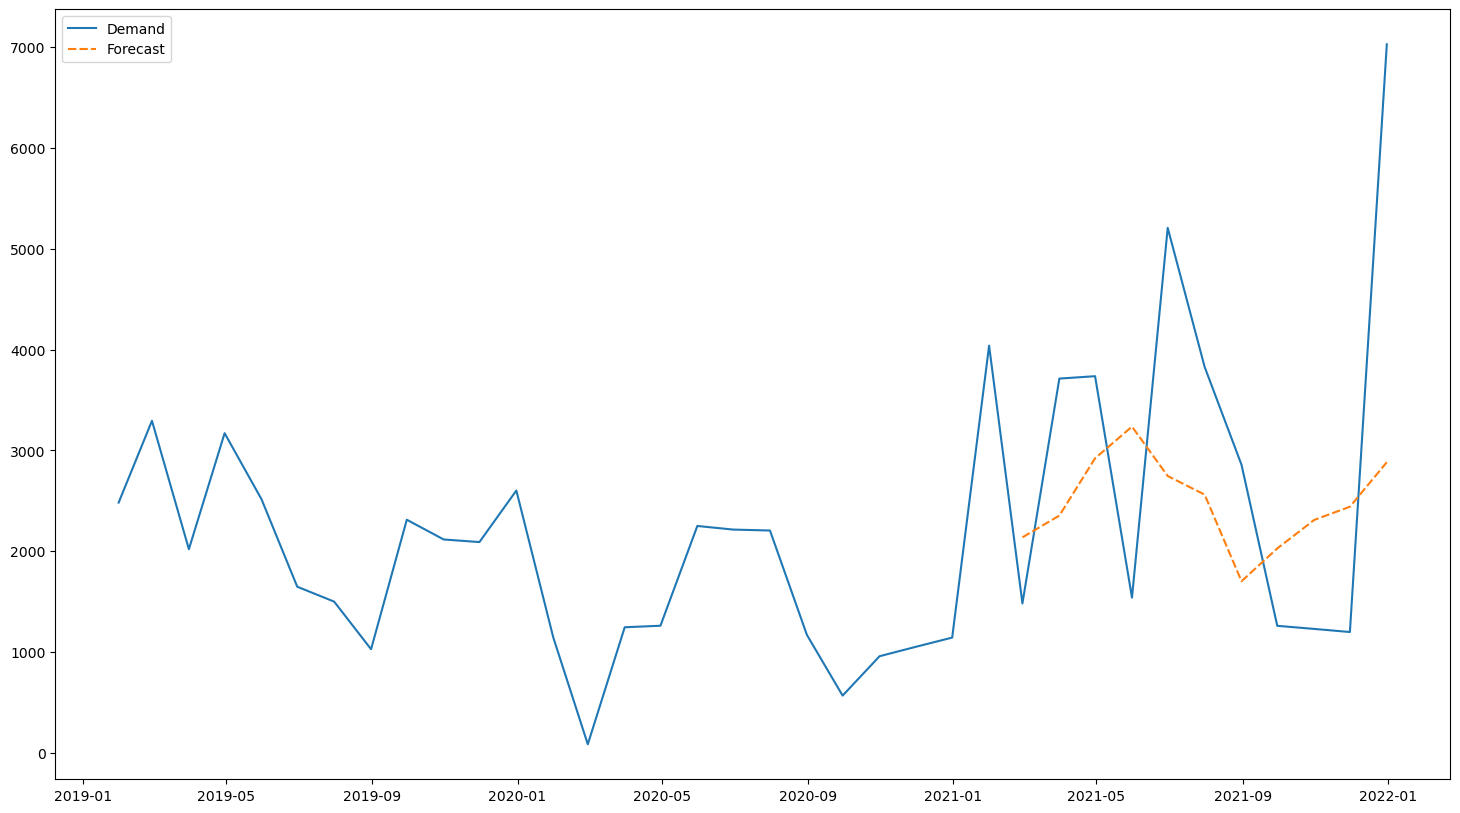

MAPE 58.70316201350961
RMSE 1792.0316842848786


In [31]:
TES = ExponentialSmoothing(Train,seasonal='add',trend='add').fit(smoothing_level=0.45,smoothing_slope=0.05,smoothing_seasonal=0.3)
PlotValidation(TES,df1)

MAPE 94.93509499319977


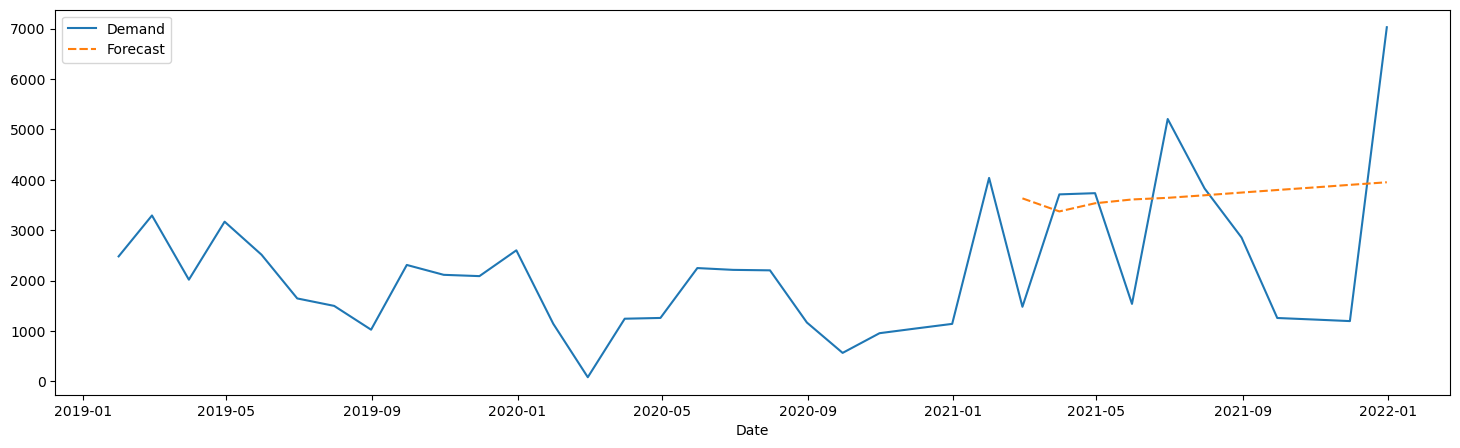

In [32]:
arimaModel = ARIMA((2,1,0),(1,0,0,52)).fit(Train)
Forecast = pd.Series(arimaModel.predict(11)).rename('Forecast')
Forecast.index = Test.index # Needed for the pd.concat to work correctly in the next line
Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)

## Validation
Validation_Df = Actual_Forecast_Df[-11:].copy()
## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
print("MAPE",np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100) # MAPE

MAPE 94.93509499319977


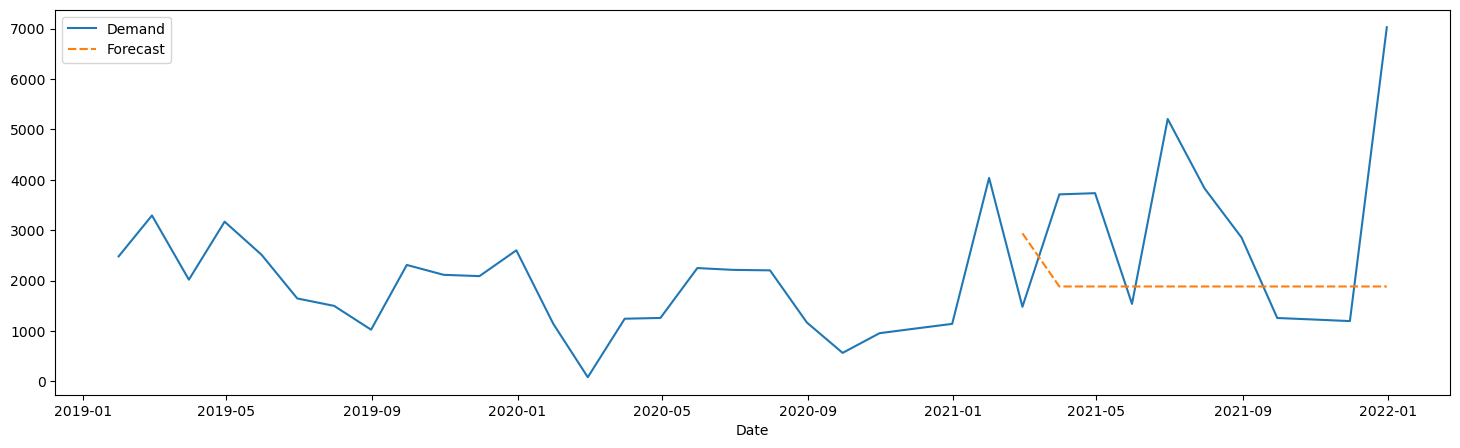

In [33]:
arimaModel2 = auto_arima(Train)
Validation_Df = Actual_Forecast_Df[-11:].copy()
Forecast = pd.Series(arimaModel2.predict(11)).rename('Forecast')
Forecast.index = Test.index
Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)

## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
print("MAPE",np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100) # MAPE

## Stationarity check

In [34]:
def test_stationarity(data):
    
    # Determining rolling statistics
    movingAvg = data.rolling(window=12).mean()
    movingStd = data.rolling(window=12).std()
    
    # Plotting
    orig = plt.plot(data,color='blue',label='original')
    mean = plt.plot(movingAvg,color='red',label='Rolling Mean')
    std = plt.plot(movingStd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean and Standard deviation")
    plt.show()
    
    # ADF Test
    dftest = adfuller(data,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','#lags used','Number of observation used'])
    print(dfoutput)
    if dfoutput[1] > 0.05:
        print('\nData is nonstationary')
    else:
        print('\nData is stationary')

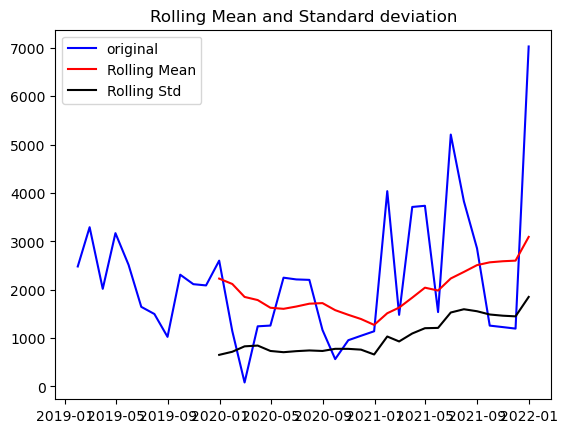

Test Statistics               -3.652437
p-value                        0.004834
#lags used                     0.000000
Number of observation used    35.000000
dtype: float64

Data is stationary


In [35]:
test_stationarity(df1)

### Forecasting with finalized model

In [36]:
Final_TES2 = ExponentialSmoothing(Train,seasonal='add',trend='add').fit(smoothing_level=0.45,smoothing_slope=0.05,smoothing_seasonal=0.3)

In [37]:
## Forecasting
Forecast = pd.Series(Final_TES2.predict(0)).rename('Forecast')
Forecast

Date
2019-01-31    2819.265923
2019-02-28    2141.526226
2019-03-31    2600.282543
2019-04-30    3036.590659
2019-05-31    3248.415636
2019-06-30    2334.319543
2019-07-31    1776.715292
2019-08-31     765.717476
2019-09-30    1326.684227
2019-10-31    1945.485876
2019-11-30    2133.395884
2019-12-31    2632.798058
2020-01-31    2517.854227
2020-02-29    1797.486476
2020-03-31     359.036642
2020-04-30    1614.924306
2020-05-31    1280.774523
2020-06-30    1119.416527
2020-07-31    1499.253925
2020-08-31    1126.982715
2020-09-30    1836.402403
2020-10-31    1175.147589
2020-11-30    1094.797330
2020-12-31    1567.304483
2021-01-31     833.628580
Freq: M, Name: Forecast, dtype: float64

In [38]:
# Set the correct dates as index of the forecast obtained in the previous line
start = "2021-12-31" 
end = "2023-12-31"
futureDateRange = pd.date_range(start, end, freq='M')

In [39]:
Forecast.index =  futureDateRange 

In [40]:
Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1) # Column wise binding

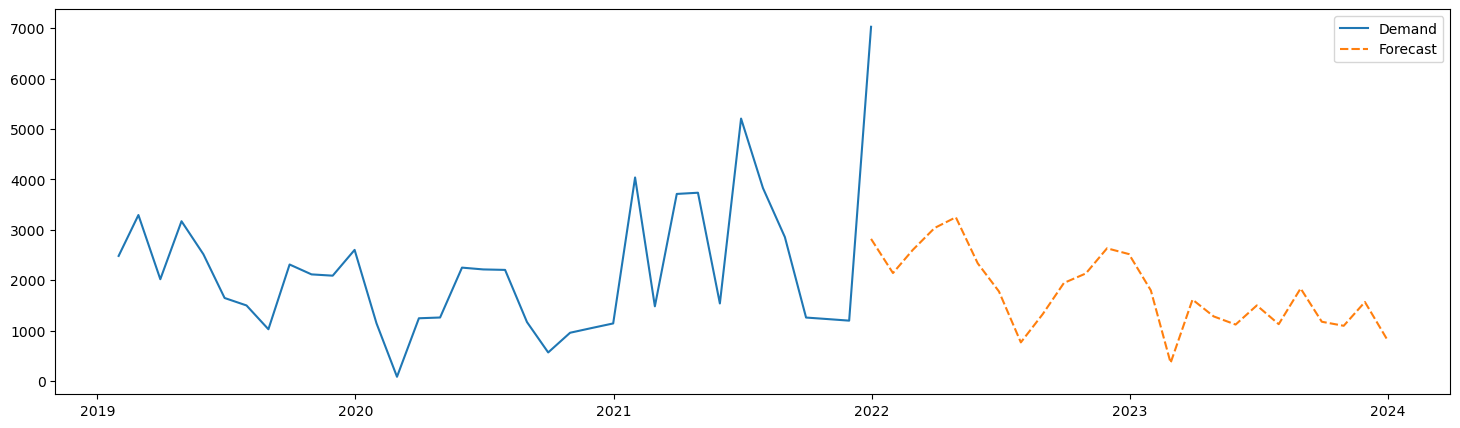

In [41]:
## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
plt.show()

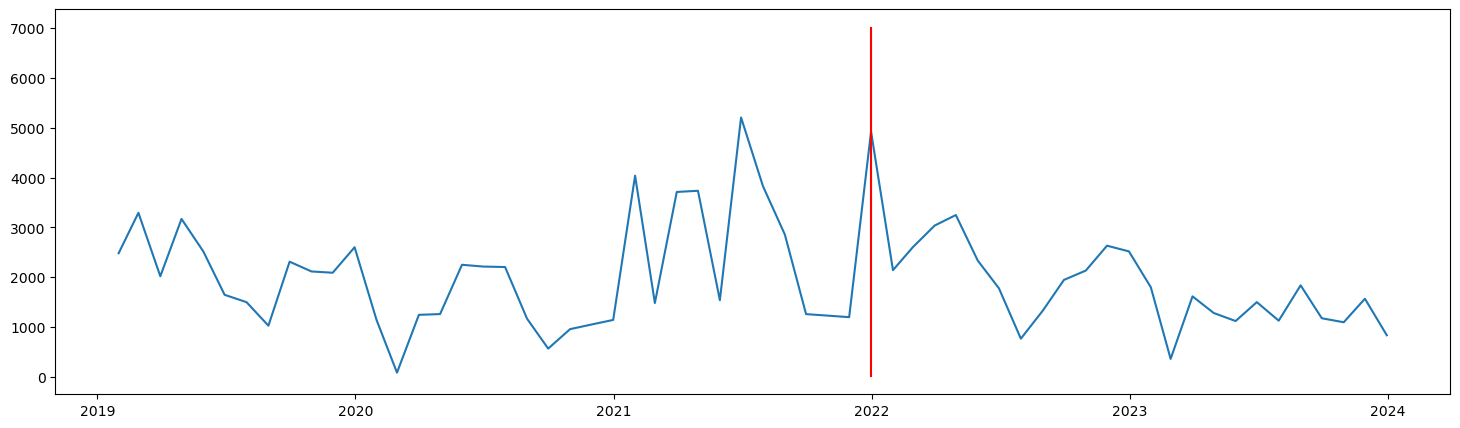

In [42]:
Actual_Forecast_Series = pd.concat([df1, Forecast], axis = 0) # Row wise binding
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Series)
vlines(x = Actual_Forecast_Series.index[36],ymin=0,ymax = max(Actual_Forecast_Series), colors = "red")
plt.show()